# Inspect data from the fa_mac_may_aug_50p_catch_continuous dataset

### Table of Contents
- show date distribution by year
- create pandas dataframe from catch dates
- populate dataframe with nk800 and copcus values
- inspect data with sns 
- conclusions

In [6]:
# Imports 
import datetime 
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt

In [38]:
def plot_date_distribution(catch_dates: set, no_catch_dates: set, df: pd.DataFrame = None) -> None:
    """
    Plot a bar chart with days with catch and no catch given two sets.
    Args:
        catch_dates: set of dates with catches
        no_catch_dates: set of dates without catches
        df: optional DataFrame containing catch data with 'Date' and 'Location' columns
    """
    # Pre-parse your date strings once
    catch_dt    = [datetime.datetime.strptime(d, '%Y-%m-%d') for d in catch_dates]
    no_catch_dt = [datetime.datetime.strptime(d, '%Y-%m-%d') for d in no_catch_dates]
    min_year = min([d.year for d in catch_dt])
    max_year = max([d.year for d in catch_dt])
    years = list(range(min_year, max_year + 1))

    # Get catch counts if df is provided
    if df is not None:
        catch_counts = df.groupby('Date')['Location'].nunique()
        max_height = max(catch_counts) * 1.1  # Add 10% padding
    else:
        max_height = 1.2

    # Create a blank figure
    fig = plt.figure(figsize=(10, 2 * len(years)))

    for idx, year in enumerate(years):
        ax = fig.add_subplot(len(years), 1, idx + 1)
        
        # Define season start/end as datetimes
        start = datetime.datetime(year, 5, 1)
        end   = datetime.datetime(year, 8, 31)

        # Filter for this year's season
        yc = [d for d in catch_dt if start <= d <= end]
        yn = [d for d in no_catch_dt if start <= d <= end]

        # Get heights for catch dates
        if df is not None:
            heights_c = [catch_counts.get(d.strftime('%Y-%m-%d'), 0) for d in yc]
        else:
            heights_c = [1]

        heights_n = [1]

        # Plot bars
        w = 0.85
        ax.bar(yc, heights_c, color='blue', width=w)
        ax.bar(yn, heights_n, color='red', width=w)

        # Limit x to the season
        ax.set_xlim(start, end)
        ax.set_ylim(0, max_height)
        
        # Show y-axis only if we have catch counts
        if df is not None:
            ax.set_ylabel('Catch Locations')
        else:
            ax.get_yaxis().set_visible(False)
        
        ax.set_title(str(year))
        ax.legend(['Catch', 'No Catch'], loc='upper right')
        ax.grid(axis='x', linestyle='--', alpha=0.5)

    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()

In [39]:
def get_file_list(directory: str) -> list:
    """
    Returns a sorted list of filenames (without path) in the specified directory.
    """
    path = Path(directory)
    files = [f.name for f in path.glob('*') if f.is_file()]
    return sorted(files)

In [40]:
copcus_path = '/home/peder/git/fish-forecast/Data/fa_mac_may_aug_50p_catch_continuous/copcus/raw'
nk800_path = '/home/peder/git/fish-forecast/Data/fa_mac_may_aug_50p_catch_continuous/nk800/raw'

copcus_data_list = get_file_list(copcus_path)
nk800_data_list = get_file_list(nk800_path)

# Check if all dates are present in bot directories
dates_check = copcus_data_list == nk800_data_list
print(f"Dates in copcus == nk800: {dates_check}")
if dates_check is not True:
    missing_in_nk800 = set(copcus_data_list) - set(nk800_data_list)
    missing_in_copcus = set(nk800_data_list) - set(copcus_data_list)
    print(f"Files in copcus but not in nk800: {missing_in_nk800}")
    print(f"Files in nk800 but not in copcus: {missing_in_copcus}")
else:
    print(f"Files in dirs: {len(nk800_data_list)}")




Dates in copcus == nk800: True
Files in dirs: 292


all 292 dates are present, we can now build the dataframe

In [41]:
df_orig = pd.read_csv("/home/peder/git/fish-forecast/Data-Exploration/catch_may_aug_2019_2024.csv", sep=';')
col = df_orig.columns
size = df_orig.shape
print(f"the df is {size}, with columns: {col}")
# Adding class catch fo all entries 
df_orig["Catch"] = True
print(f"New columns: {df_orig.columns}")

# Get a list of all days with catches
catch_dates = list(df_orig['Date'].unique())
print(f"{size[0]} catches on {len(catch_dates)} unique days")
df = df_orig.drop(['Location', 'Date'], axis=1)
print(f"New columns: {df.columns}")

the df is (898, 5), with columns: Index(['Rundvekt', 'CatchLat', 'CatchLon', 'Location', 'Date'], dtype='object')
New columns: Index(['Rundvekt', 'CatchLat', 'CatchLon', 'Location', 'Date', 'Catch'], dtype='object')
898 catches on 146 unique days
New columns: Index(['Rundvekt', 'CatchLat', 'CatchLon', 'Catch'], dtype='object')


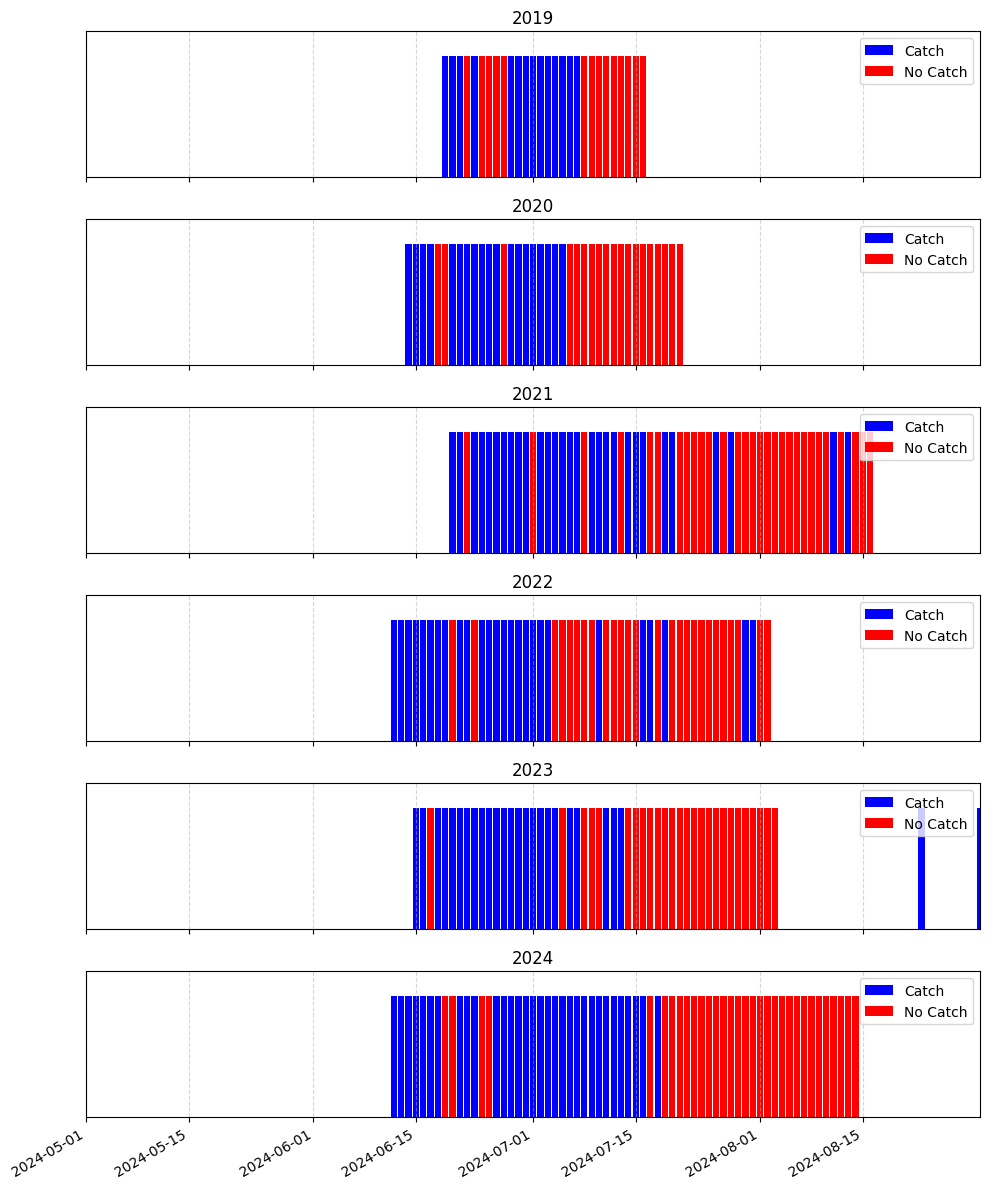

146 days w/catch, 146 days w/o catch, total= 292


In [42]:
all_dates = []
for d in nk800_data_list:
    all_dates.append(d[:-3])

no_catch_dates = sorted(set(all_dates) - set(catch_dates))

plot_date_distribution(catch_dates, no_catch_dates)
print(f"{len(catch_dates)} days w/catch, {len(no_catch_dates)} days w/o catch, total= {len(all_dates)}")

Lets add the dates with no catch, and label them

all dates are there: True


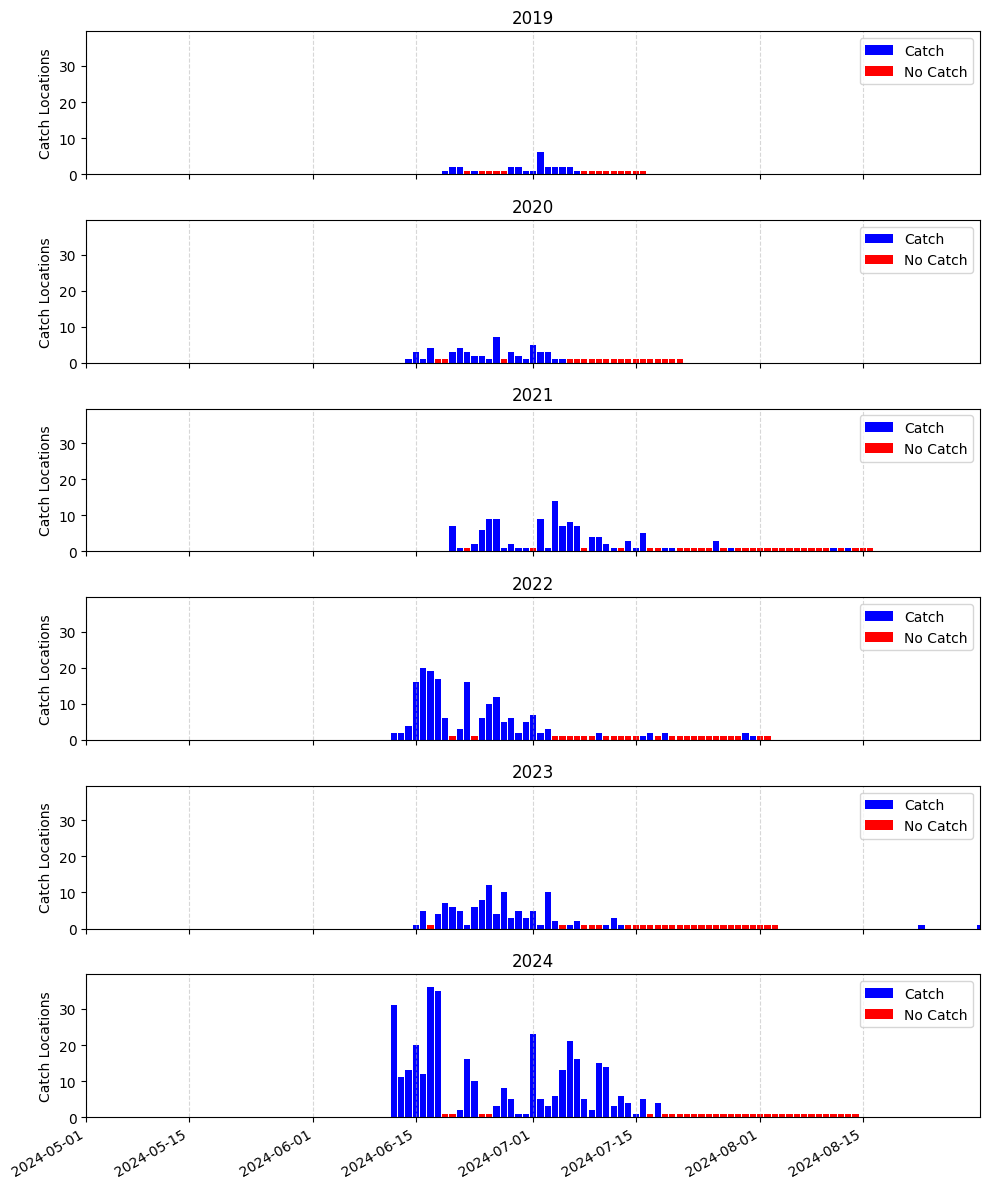

In [43]:
# TODO: copy the catch df and change dates to no catch i.e. catch_dates[i] = no_catch_dates[i], then combine the dataframes

df_no_catch = df_orig.copy()
df_no_catch['Catch'] = False
df_catch = df_orig.copy()

for d in range(len(catch_dates)):
    df_no_catch.loc[df_no_catch['Date'] == catch_dates[d], 'Date'] = no_catch_dates[d]

# Check that the dates are correct
check = df_no_catch['Date'].unique() == no_catch_dates
print(f"all dates are there: {check.all()}")

df_all = pd.concat([df_catch, df_no_catch])
# Sort the combined dataframe by date
df_all = df_all.sort_values('Date').reset_index(drop=True)

plot_date_distribution(catch_dates, no_catch_dates, df_all)
# df_all.to_csv('fa_mac_may_aug_50p_catch_continuous.csv', sep=';', index=False)

In [9]:
# combine the two dataframes and get variables from the dataset
df_all = pd.concat([df_catch, df_no_catch])
# Sort the combined dataframe by date
df_all = df_all.sort_values('Date').reset_index(drop=True)

depths = [0, 3, 10, 15, 25, 50]  # NK800 depths

# base paths
datasets = {
    'cop': copcus_path,    
    'nk8': nk800_path,     
}

# will collect one dict per row
data_variables = []

for idx, row in df_all.iterrows():
    date = row['Date']
    lat  = row['CatchLat']
    lon  = row['CatchLon']
    combined = {}

    for prefix, base in datasets.items():
        fn = f"{base}/{date}.nc"
        try:
            ds = xr.open_dataset(fn)

            if prefix == 'cop':
                # 1D coords: nearest lat/lon
                da = ds.sel(latitude=lat, longitude=lon, method='nearest')
                for var in ds.data_vars:
                    arr = da[var]
                    if 'depth' in arr.dims:
                        for d in depths:
                            # Find nearest depth in copcus data
                            depth_idx = abs(ds.depth - d).argmin()
                            sel = arr.isel(depth=depth_idx, **({'time':0} if 'time' in arr.dims else {}))
                            combined[f"cop_{var}_d{d}"] = float(sel.values)

            else:  # nk800
                # grab the 2D lat/lon arrays
                arr_lat = ds['lat'].values
                arr_lon = ds['lon'].values
                dist2   = (arr_lat - lat)**2 + (arr_lon - lon)**2
                idx_flat = dist2.argmin()
                ny, nx   = arr_lat.shape
                y_idx, x_idx = divmod(int(idx_flat), nx)

                # Add all 2D variables at the nearest point
                for var in ['temperature', 'salinity', 'u', 'v', 'w']:
                    for d_idx, d in enumerate(depths):
                        val = ds[var].isel(time=0, depth=d_idx, Y=y_idx, X=x_idx).values
                        combined[f'nk800_{var}_d{d}'] = float(val)

                # Add bathymetry (single value)
                h_value = ds['h'].isel(Y=y_idx, X=x_idx).values
                combined['nk800_h'] = float(h_value)

            ds.close()

        except FileNotFoundError:
            print(f"  → missing file: {fn}")
        except Exception as e:
            print(f"  → error reading {fn}: {e}")

    data_variables.append(combined)

# stitch it back on
vars_df = pd.DataFrame(data_variables)
df_all_depths = pd.concat([df_all.reset_index(drop=True), vars_df], axis=1)


In [20]:
df_all_depths.to_csv('catch_no_catch_env_data_all_depths.csv', sep=';', index=False)

In [10]:
# df_depth_0.to_csv(f'catch_no_catch_env_depth{depth}_data.csv', sep=';', index=False)

Rundvekt: median = 6500.0, avg = 11312.472160356347


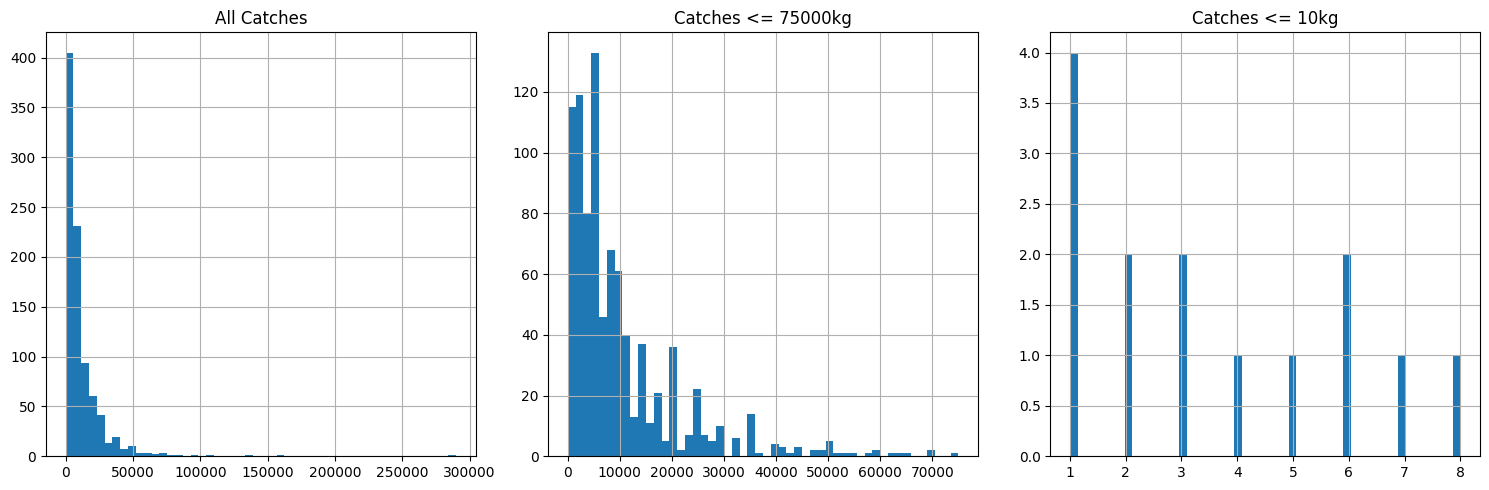

In [11]:
lower_bound = 75_000
bottom_bound = 10

print(f"Rundvekt: median = {df['Rundvekt'].median()}, avg = {df['Rundvekt'].mean()}")

df_lower = df[df['Rundvekt'] <= lower_bound]
df_bottom = df[df['Rundvekt']<= bottom_bound]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
df['Rundvekt'].hist(ax=ax1, bins=50)
ax1.set_title('All Catches')
df_lower['Rundvekt'].hist(ax=ax2, bins=50)
ax2.set_title(f'Catches <= {lower_bound}kg')
df_bottom['Rundvekt'].hist(ax=ax3, bins=50)
ax3.set_title(f'Catches <= {bottom_bound}kg')
plt.tight_layout()

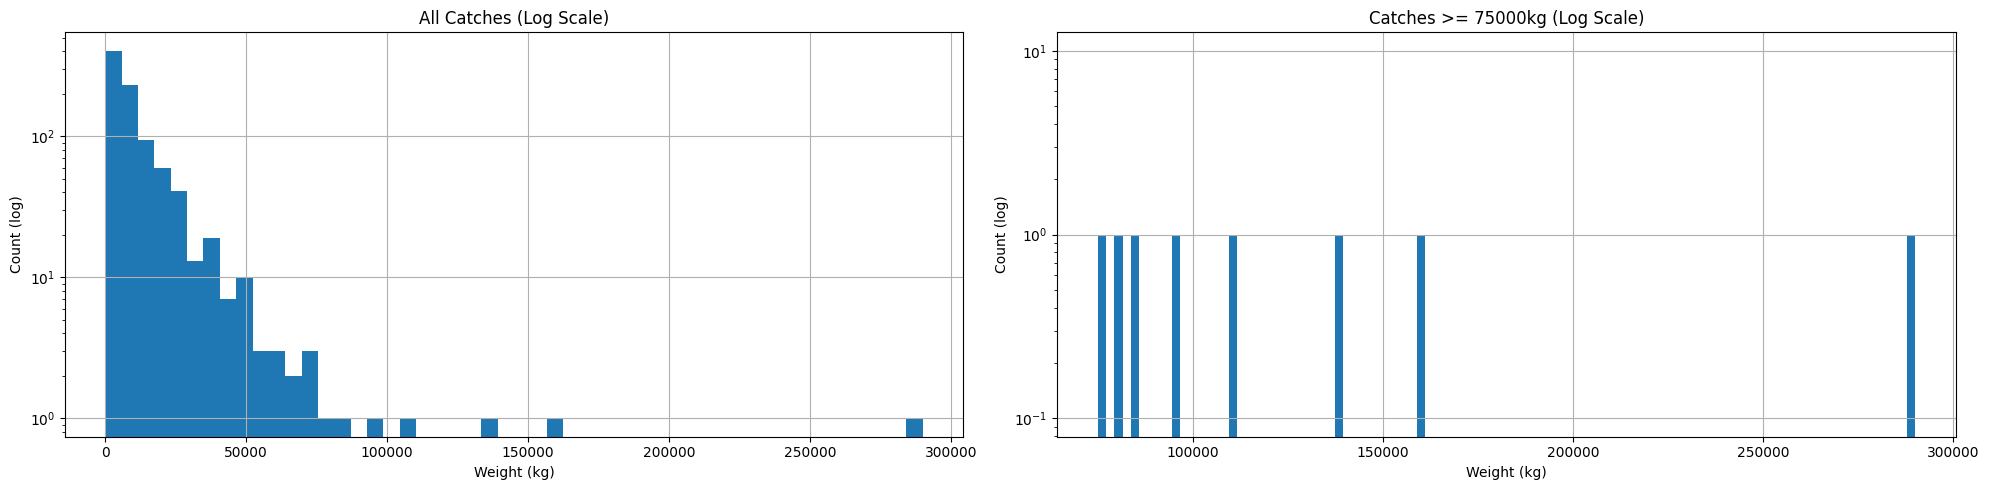

In [12]:
df_upper = df[df['Rundvekt'] >= lower_bound]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

# First plot: all catches
df['Rundvekt'].hist(bins=50, log=True, ax=ax1)
ax1.set_title('All Catches (Log Scale)')
ax1.set_xlabel('Weight (kg)')
ax1.set_ylabel('Count (log)')

# Second plot: upper bound catches
df_upper['Rundvekt'].hist(bins=100, log=True, ax=ax2)
ax2.set_title(f'Catches >= {lower_bound}kg (Log Scale)')
ax2.set_xlabel('Weight (kg)')
ax2.set_ylabel('Count (log)')

plt.tight_layout()

In [13]:
bins = np.linspace(df['Rundvekt'].min(),
                   df['Rundvekt'].max(),
                   num=6)    # 5 classes → 6 edges
labels = ["very small","small","medium","large","very large"]
df["w_class"] = pd.cut(df['Rundvekt'], bins=bins, labels=labels)

df["q_class"] = pd.qcut(df['Rundvekt'],
                         q=4,                     # quartiles
                         labels=["Q1","Q2","Q3","Q4"])
df.columns

Index(['Rundvekt', 'CatchLat', 'CatchLon', 'Catch', 'w_class', 'q_class'], dtype='object')

In [14]:
ds_c = xr.open_dataset('/home/peder/git/fish-forecast/Data/fa_mac_may_aug_50p_catch_continuous/nk800/raw/2019-06-25.nc')
ds_c.depth

# ds_n = xr.open_dataset('/home/peder/git/fish-forecast/Data/fa_mac_may_aug_50p_catch_continuous/nk800/raw/2019-06-25.nc')
# print(ds_n.depth)

<xarray.DataArray 'depth' (depth: 6)> Size: 48B
array([ 0.,  3., 10., 15., 25., 50.])
Coordinates:
  * depth    (depth) float64 48B 0.0 3.0 10.0 15.0 25.0 50.0
Attributes:
    units:          m
    positive:       down
    axis:           Z
    standard_name:  depth
    _ChunkSizes:    16

copcus depth = array([0.000e+00, 2.000e+00, 3.000e+00, 4.000e+00, 5.000e+00, 6.000e+00,
       8.000e+00, 1.000e+01, 1.100e+01, 1.300e+01, 1.600e+01, 1.800e+01,
       2.200e+01, 2.500e+01, 2.900e+01, 3.400e+01, 4.000e+01, 4.700e+01,
       5.600e+01, 6.600e+01, 7.800e+01, 9.200e+01, 1.100e+02, 1.310e+02,
       1.560e+02, 1.860e+02, 2.220e+02, 2.660e+02, 3.180e+02, 3.800e+02,
       4.540e+02, 5.410e+02, 6.440e+02, 7.630e+02, 9.020e+02, 1.062e+03,
       2.000e+03, 3.000e+03, 3.500e+03, 4.000e+03], dtype=float32)

nk depth = array([ 0.,  3., 10., 15., 25., 50.])

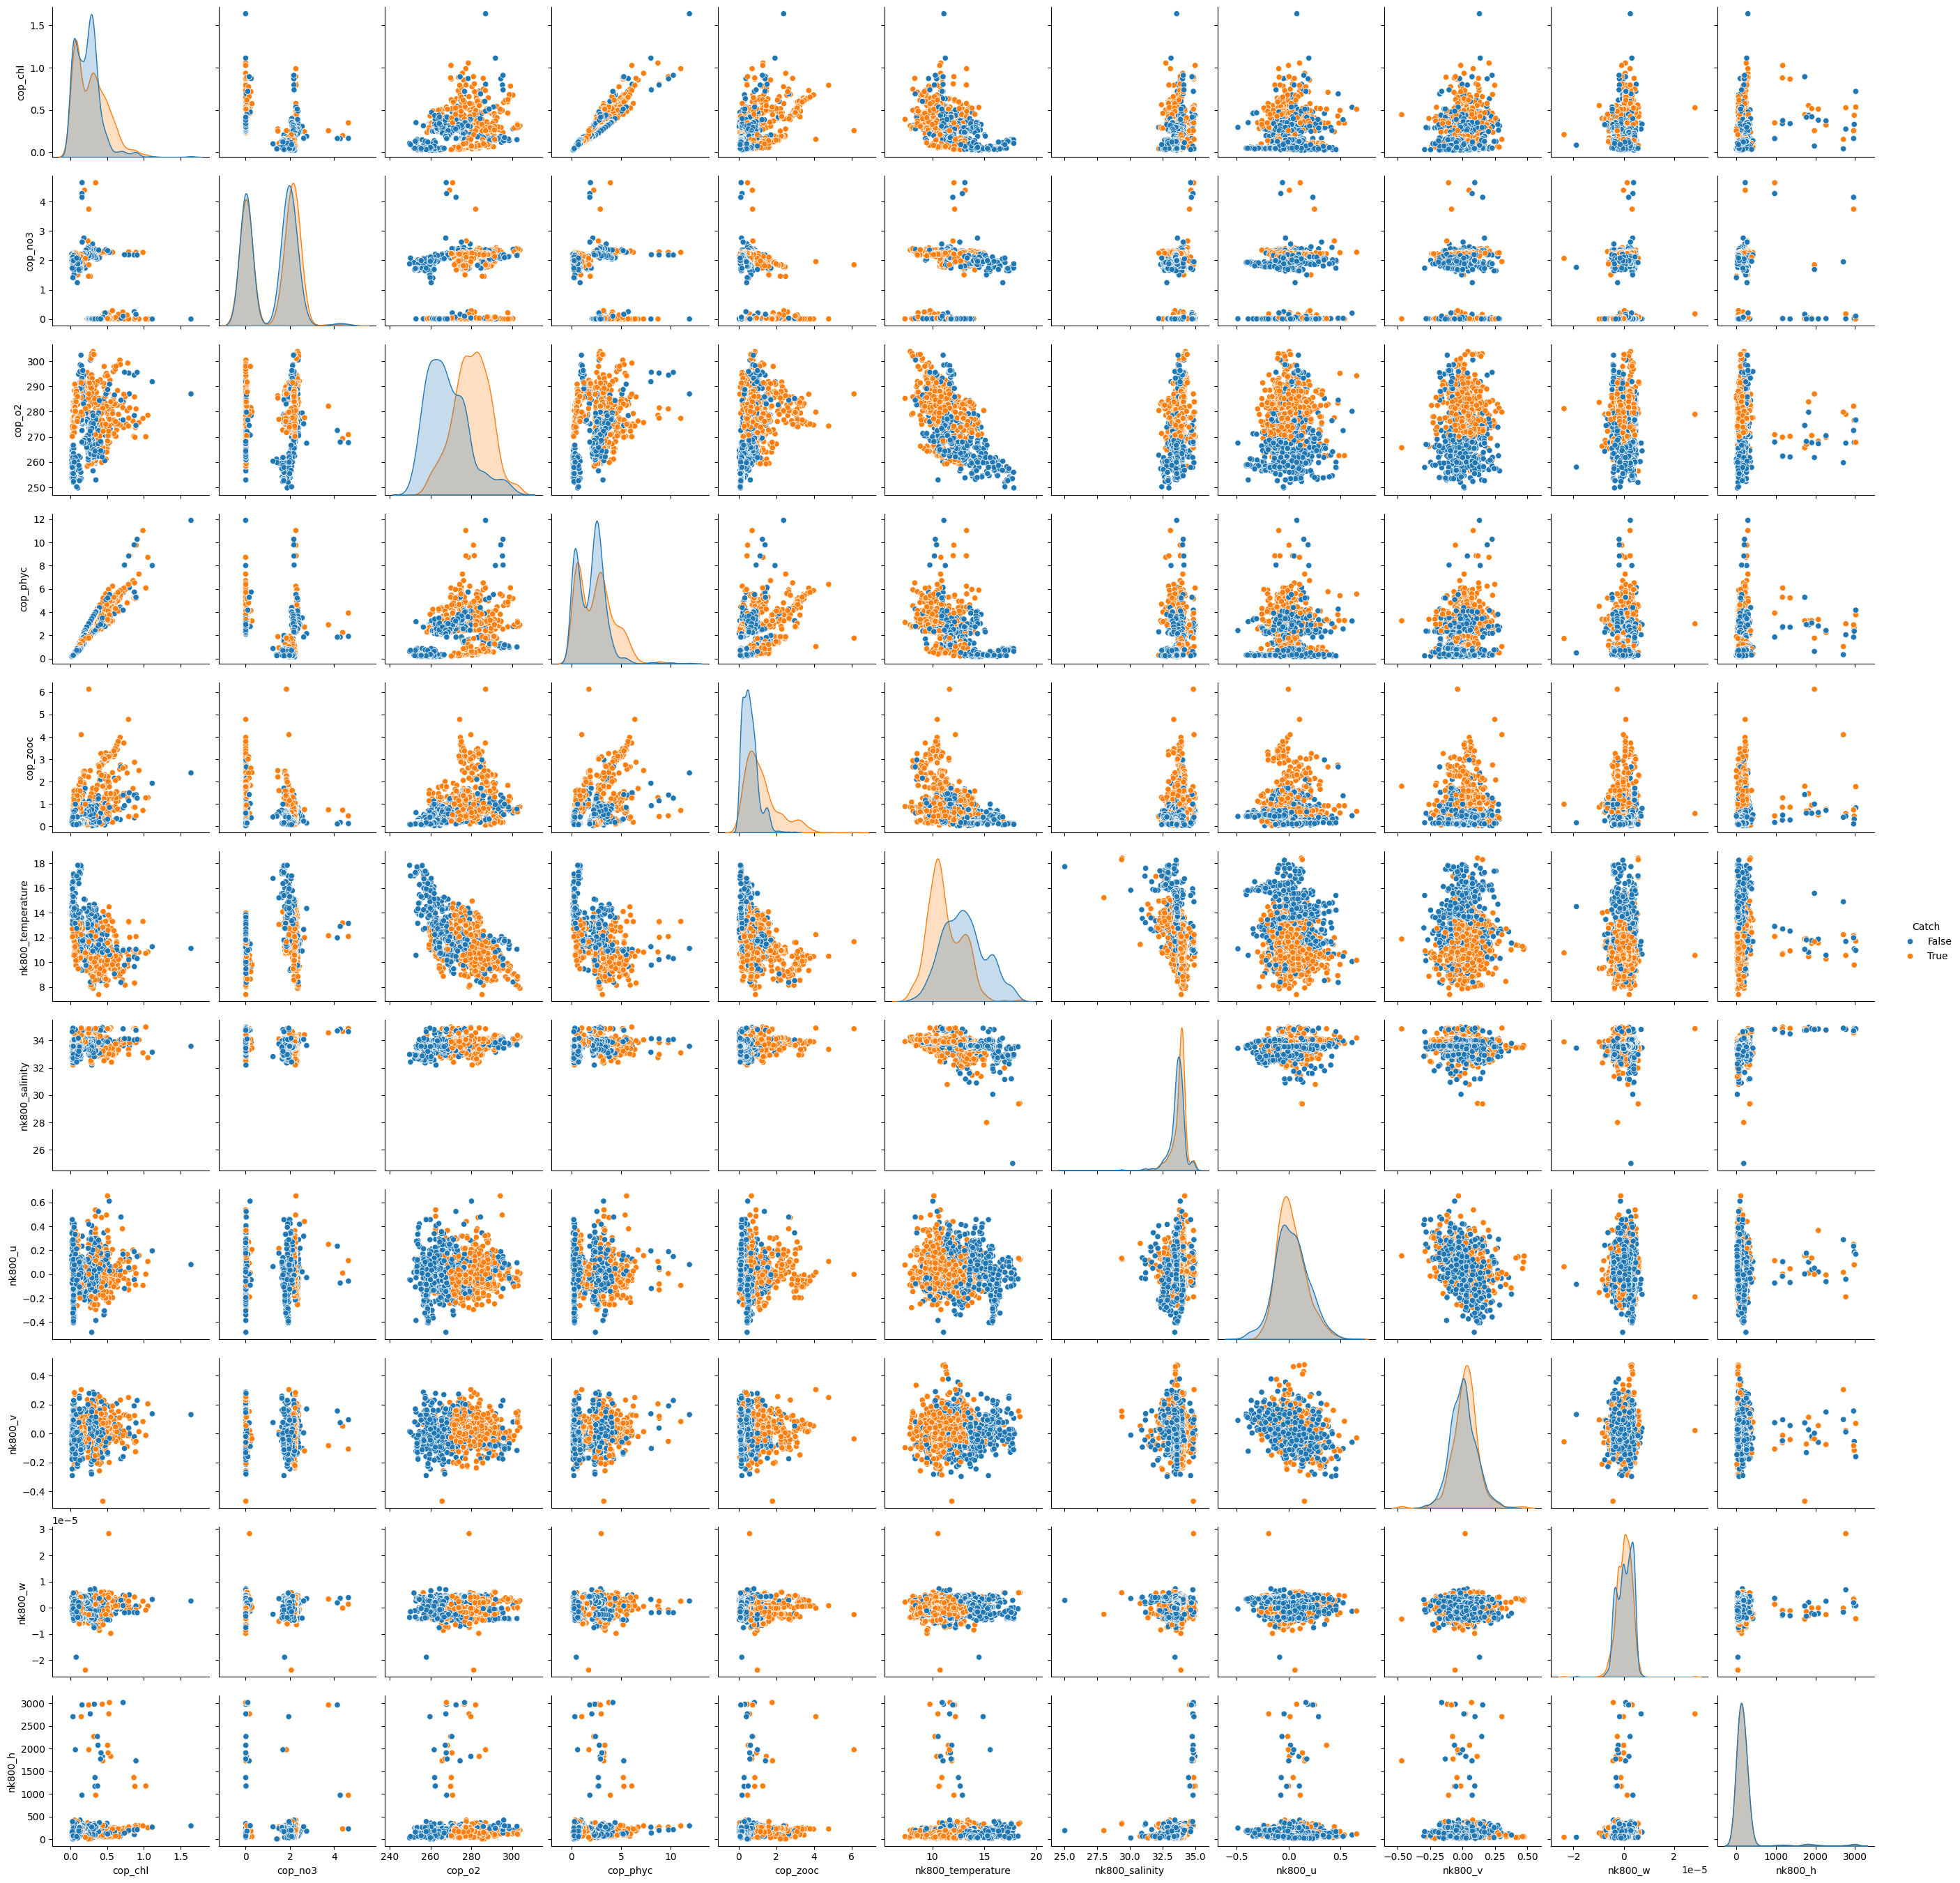

In [15]:
target_w = 'w_class'
target_wq = 'q_class'
target_c = 'Catch'
df_env = df_depth_0
df_env = df_env.drop(['Location', 'Date', 'CatchLat', 'CatchLon', 'Rundvekt'], axis=1)
# sns.pairplot(df, diag_kind='kde', hue=target_w)
# sns.pairplot(df, diag_kind='kde', hue=target_wq)
sns.pairplot(df_env, diag_kind='kde', hue=target_c)

<Axes: >

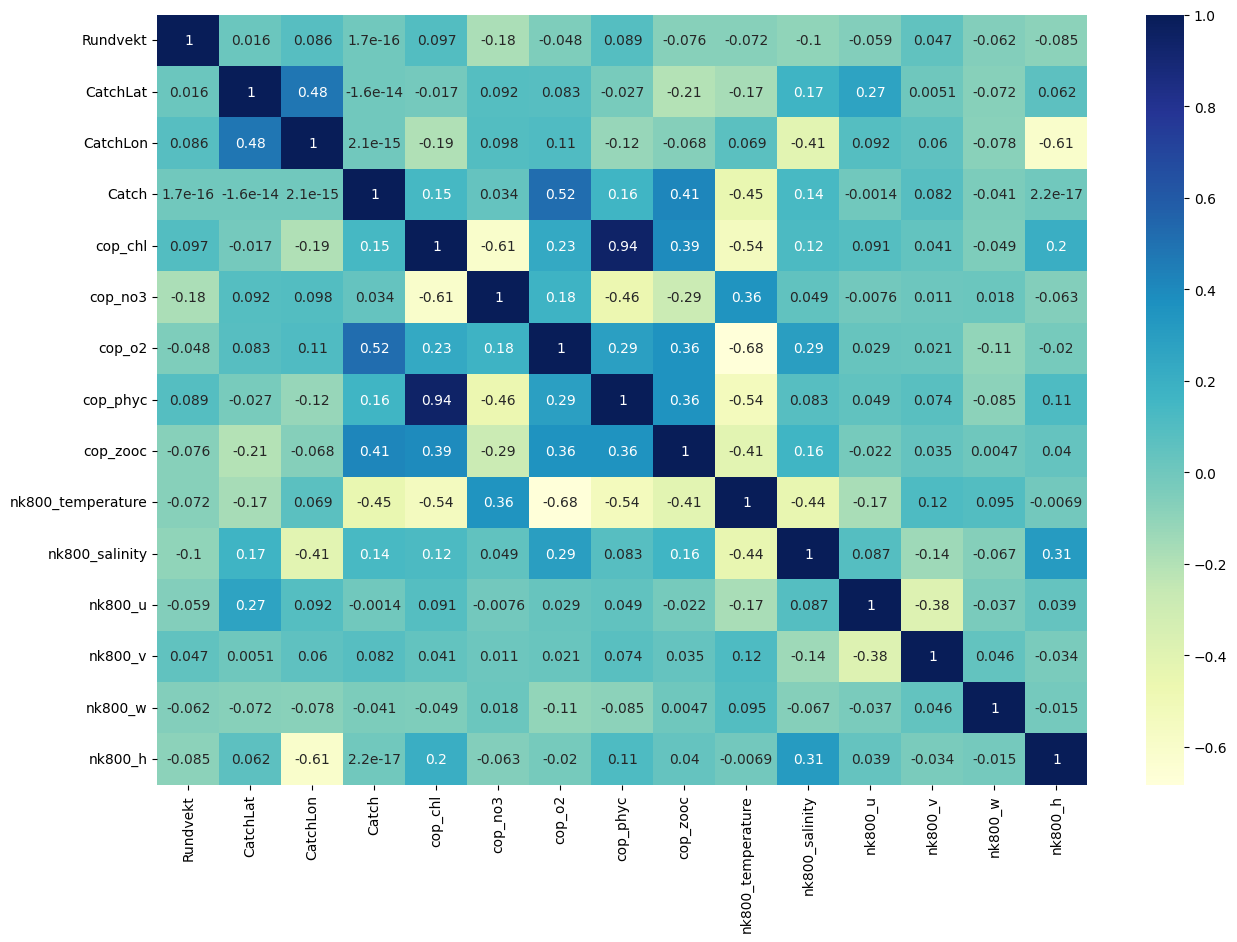

In [16]:
df_corr = df_depth_0.drop(['Location', 'Date'], axis=1)
corr = df_depth_0[df_corr.columns].corr()
plt.figure(figsize=(15,10)) # set X and Y size
sns.heatmap(corr, cmap="YlGnBu", annot=True)

### Notable corrolations:
| Variable (depth = 0)| Correlation with Catch |
|----------|---------------------|
| cop_o2 | 0.54 |
| nk800_temperature | -0.45 |
| cop_zooc | 0.41 |
| cop_phyc | 0.16 |
| cop_chl | 0.15 |
| nk800_salinity | 0.14 |

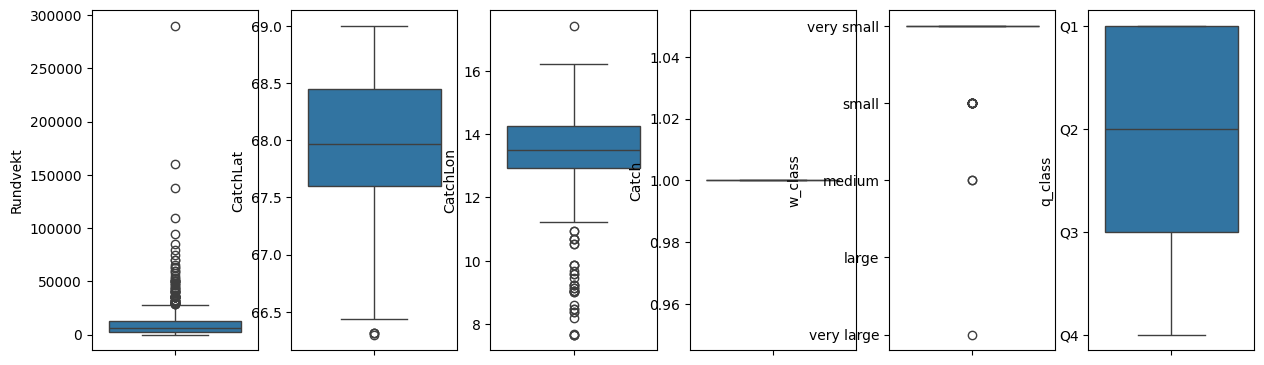

In [17]:

#--Checking Outliers
plt.figure(figsize=(15,15))
pos = 1
# print(df.columns)
for i in df.columns:
    plt.subplot(3, 6, pos)
    sns.boxplot(data=df[i])
    pos += 1

Index(['Rundvekt', 'CatchLat', 'CatchLon', 'Catch', 'w_class', 'q_class'], dtype='object')


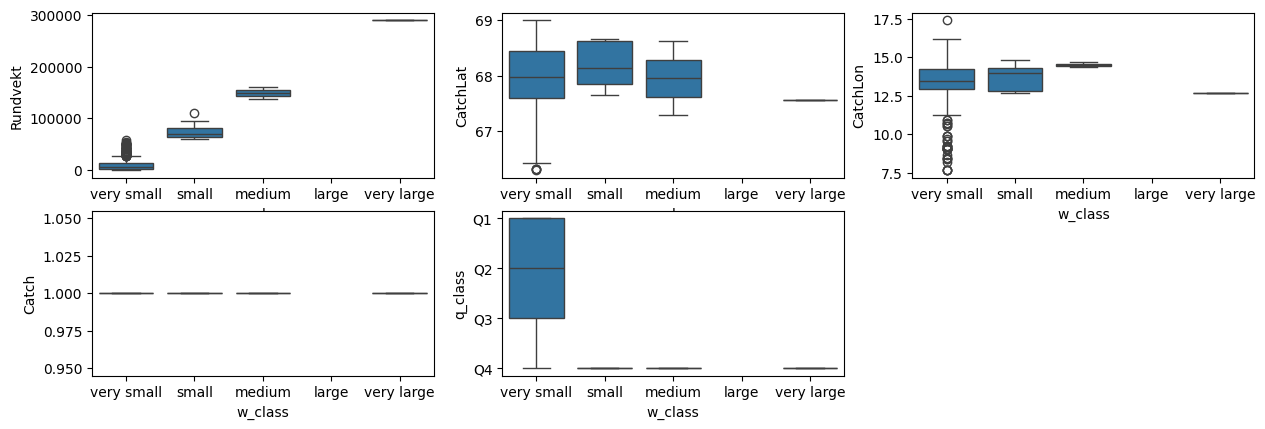

In [18]:
target = target_w
predictors = list(df.columns)
print(df.columns)
predictors.remove(target)
predictors
#--Checking Outliers
plt.figure(figsize=(15,15))
pos = 1
for p in predictors:
    plt.subplot(6, 3, pos)
    sns.boxplot(x=target, y=p, data=df)
    pos += 1